In [82]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import random
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error


In [83]:
def define_files():
    files = {
        "air_pollution_death": "data/air_pollution_death.csv",
        "transportation": 'data/road-transportation_country_emissions.csv',
        "coal": 'data/coal-mining_country_emissions.csv',
        "cropland": 'data/cropland-fires_country_emissions.csv',
        "residential_commercial": 'data/residential-and-commercial-onsite-fuel-usage_country_emissions.csv',
        "forest_clearing": 'data/forest-land-clearing_country_emissions.csv',
        "petrochemicals": 'data/petrochemicals_country_emissions.csv',
        "electricity_generation": 'data/electricity-generation_country_emissions.csv',
        "incineration_open_burning": 'data/incineration-and-open-burning-of-waste_country_emissions.csv',
        "health_expenditure": 'data/health-expenditure.csv',
        "urban_population": 'data/urban-population.csv'
    }
    return files

files = define_files()


In [84]:
# Finding common country codes

environment_factor_files_list = [
        'transportation',
        'coal',
        'cropland',
        'residential_commercial',
        'forest_clearing',
        'petrochemicals',
        'electricity_generation',
        'incineration_open_burning'
    ]
    
socioeconomic_files_list = [
    'health_expenditure',
    'urban_population'
]

def find_common_country_codes(env_list, socio_list, files):
    env_codes = []
    socio_codes = []
    
    for factor in env_list:
        df = pd.read_csv(files[factor])
        codes = set(df['iso3_country'].unique())
        env_codes.append(codes)
    common_env_codes = set.intersection(*env_codes) if env_codes else set()


    for factor in socio_list:
        df = pd.read_csv(files[factor], skiprows=4)
        codes = set(df['Country Code'].unique())
        socio_codes.append(codes)
    common_socio_codes = set.intersection(*socio_codes) if socio_codes else set()

    common_country_codes = sorted(list(common_env_codes.intersection(common_socio_codes)))
    return common_country_codes

common_country_codes = find_common_country_codes(environment_factor_files_list, socioeconomic_files_list, files)


In [85]:
# Filtering Air Pollution data (from air_pollution_death.csv)

air_pollution_df = pd.read_csv(files['air_pollution_death'])

filtered_air_pollution_df = air_pollution_df[
    (air_pollution_df['SpatialDimValueCode'].isin(common_country_codes)) &
    (air_pollution_df['Period'] == 2018) &
    (air_pollution_df['Dim1'] == 'Both sexes')
]


In [86]:
# Filtering feature data and aggregating feature values per country

environment_data = []
socioeconomic_data = []

for factor in environment_factor_files_list:
    df = pd.read_csv(files[factor])

    df_filtered = df[
        (df['iso3_country'].isin(common_country_codes)) &
        (df['start_time'] >= '2018-01-01 00:00:00')
    ]
    
    df_grouped = df_filtered.groupby('iso3_country', as_index=False)['emissions_quantity'].sum()
    df_grouped.rename(columns={'iso3_country': 'Country Code', 'emissions_quantity': factor}, inplace=True)
    environment_data.append(df_grouped)

for factor in socioeconomic_files_list:
    df = pd.read_csv(files[factor], skiprows=4)

    df_filtered = df[df['Country Code'].isin(common_country_codes)]
    df_filtered = df_filtered[['Country Code', '2018']].rename(columns={'2018': factor})
    socioeconomic_data.append(df_filtered)



In [87]:
# Merging all features into one data frame

deaths_by_country = filtered_air_pollution_df.groupby(['SpatialDimValueCode'])['FactValueNumeric'].sum().reset_index()
deaths_by_country.rename(columns={'SpatialDimValueCode': 'Country Code', 'FactValueNumeric': 'Air Pollution Deaths'}, inplace=True)

environment_merged = environment_data[0]
for df in environment_data[1:]:
    environment_merged = pd.merge(environment_merged, df, on='Country Code', how='outer')

final_merged = environment_merged
for df in socioeconomic_data:
    final_merged = pd.merge(final_merged, df, on='Country Code', how='outer')

final_merged = pd.merge(final_merged, deaths_by_country, on='Country Code', how='outer')
final_merged = final_merged.dropna()

missing_threshold = 0.5 * len(final_merged)
columns_to_drop = final_merged.columns[final_merged.isnull().sum() > missing_threshold]
final_merged = final_merged.drop(columns=columns_to_drop)
final_merged.to_csv('final merged')

factors = final_merged
final_merged_with_outlier = final_merged
final_merged = final_merged[final_merged['Country Code'] != 'CHN']
final_merged = final_merged[final_merged['Country Code'] != 'IND']
# final_merged.head()

In [88]:
rename_dict = {
    "transportation": "Transportation Emissions",
    "coal": "Coal Mining Emissions",
    "cropland": "Cropland Fires Emissions",
    "residential_commercial": "Residential & Commercial Emissions",
    "forest_clearing": "Forest Clearing Emissions",
    "petrochemicals": "Petrochemicals Emissions",
    "electricity_generation": "Electricity Generation Emissions",
    "incineration_open_burning": "Incineration & Open Burning Emissions",
    "health_expenditure": "Health Expenditure",
    "urban_population": "Urban Population"
}

# Rename the columns in the DataFrame
final_merged.rename(columns=rename_dict, inplace=True)
final_merged_with_outlier.rename(columns=rename_dict, inplace=True)


In [ ]:
# Determining X and y values and applying dataset standardization

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

X = final_merged_with_outlier.drop(columns=['Country Code', 'Air Pollution Deaths'])
y = final_merged_with_outlier['Air Pollution Deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


ValueError: Found input variables with inconsistent numbers of samples: [176, 174]

In [ ]:
# Creating, training, and testing the model

# {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.3, 'gamma': 0, 'reg_alpha': 100, 'reg_lambda': 1, 'train_r2': 0.974334007523811, 'test_r2': 0.8997231261698432}
#PARAMETERS WHEN EXCLUDING CHINA AND INDIA
'''
model = xgb.XGBRegressor(
    tree_method='hist',
    n_estimators=200, #600
    learning_rate=0.065, #0.065
    max_depth=3, #1
    gamma=0, #1
    
    subsample=0.3, #0.042
    colsample_bytree=0.7, #1
    reg_alpha=10, #80000
    reg_lambda=10, #60
    random_state=random_seed
)

'''
#Best Hyperparameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 2, 'subsample': 0.3, 'gamma': 0, 'colsample_bytree': 0.7, 'reg_alpha': 1000, 'reg_lambda': 1, 'train_r2': 0.9582780966393493, 'test_r2': 0.6115232954800243}
# PARAMETERS WHEN INCLUDING CHINA AND INDIA
model = xgb.XGBRegressor(
    tree_method='hist',
    n_estimators=200, #600
    learning_rate=0.1, #0.065
    max_depth=2, #1
    gamma=0, #1
    
    subsample=0.3, #0.042
    colsample_bytree=0.7, #1
    reg_alpha=1000, #80000
    reg_lambda=1, #60
    random_state=random_seed
)
evalset = [(X_train_scaled, y_train), (X_test_scaled,y_test)]
model.fit(X_train_scaled, y_train, eval_set=evalset, verbose=False)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
result = model.evals_result()

final_train_r2 = train_r2
final_test_r2 = test_r2
# print(model.score(X_test_scaled, y_test))
print(f"Train R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

Train R² Score: 0.9882
Test R² Score: 0.7125


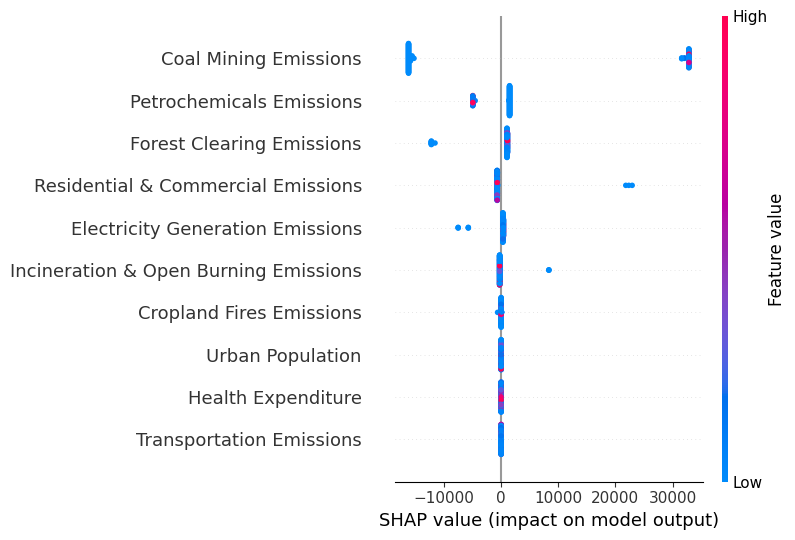

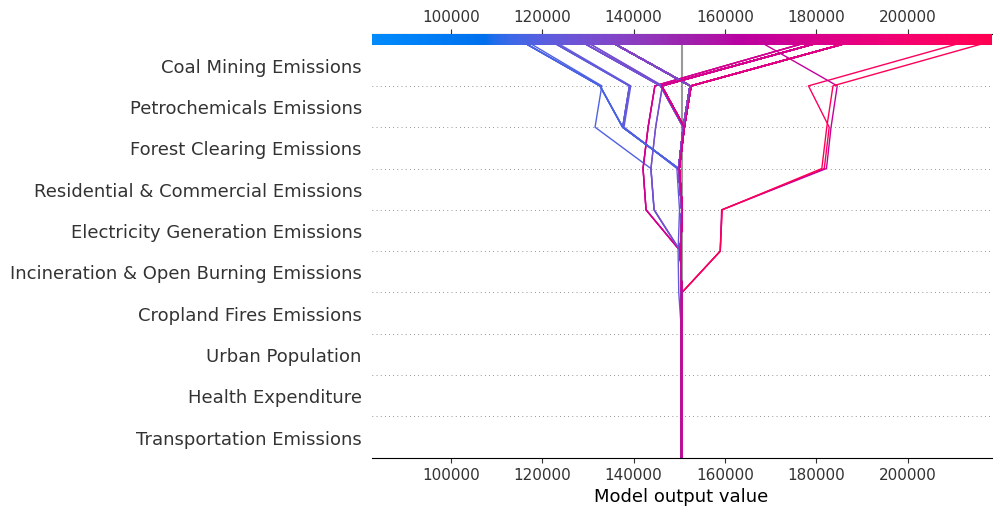

'<img src="beeswarm_plot2.png" alt="SHAP Beeswarm Plot" width="800">'

In [ ]:
def generate_beeswarm_plot(model, X_train):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="dot")
    

    plt.figure(figsize=(10,6))
    shap.plots.beeswarm(shap_values, show=False)
    plt.savefig("beeswarm_plot2.png", bbox_inches='tight')
    plt.close()

    
    shap.decision_plot(explainer.expected_value, shap_values.values, X_train)
    return '<img src="beeswarm_plot2.png" alt="SHAP Beeswarm Plot" width="800">'
generate_beeswarm_plot(model, X_train)


In [ ]:
scatter_html_blocks = []
for column in X:
    correlation = final_merged[[column, 'Air Pollution Deaths']].corr().iloc[0, 1]
    
    fig = px.scatter(final_merged, x=column, y='Air Pollution Deaths', hover_data=['Country Code'])

    fig.add_annotation(
    x=max(final_merged[column]),
    y=max(final_merged['Air Pollution Deaths']),
    text=f"Correlation: {correlation:.4f}",
    showarrow=False,
    font=dict(size=14, color="red"))

    scatter_html_blocks.append(fig)

# for i in scatter_html_blocks:
#     i.show()

In [ ]:
print("final_merged_with_outlier columns:", final_merged_with_outlier.columns)
print("final_merged columns:", final_merged.columns)

final_merged_with_outlier columns: Index(['Country Code', 'Transportation Emissions', 'Coal Mining Emissions',
       'Cropland Fires Emissions', 'Residential & Commercial Emissions',
       'Forest Clearing Emissions', 'Petrochemicals Emissions',
       'Electricity Generation Emissions',
       'Incineration & Open Burning Emissions', 'Health Expenditure',
       'Urban Population', 'Air Pollution Deaths'],
      dtype='object')
final_merged columns: Index(['Country Code', 'Transportation Emissions', 'Coal Mining Emissions',
       'Cropland Fires Emissions', 'Residential & Commercial Emissions',
       'Forest Clearing Emissions', 'Petrochemicals Emissions',
       'Electricity Generation Emissions',
       'Incineration & Open Burning Emissions', 'Health Expenditure',
       'Urban Population', 'Air Pollution Deaths'],
      dtype='object')


In [ ]:


def generate_html_file():
    rounded_train_r2 = round(train_r2, 2)
    rounded_test_r2 = round(test_r2, 2)
    scatter_html_blocks = []
    scatter_html_blocks_with_outlier = []
    spcounter = 1
    spcounter2 = 1

    for column in X:
        correlation = final_merged[[column, 'Air Pollution Deaths']].corr().iloc[0, 1]
        correlation_outliers = final_merged_with_outlier[[column, 'Air Pollution Deaths']].corr().iloc[0, 1]
        
        fig = px.scatter(final_merged, 
                         x=column, 
                         y='Air Pollution Deaths', 
                         hover_data=['Country Code'],
                         text=final_merged['Country Code'],
                         title= f'{column} vs Air Pollution Deaths (Excl. CHN & IND) (Correlation: {round(correlation, 2)})',
                         height=600,
                         width=1000
                         )

        
        fig.update_traces(textposition='top center', marker=dict(size=8))
        fig.update_layout(title_x=0.5, title_y=0.9)
        fig.add_annotation(
            x=max(final_merged['Health Expenditure']),
            y=max(final_merged['Air Pollution Deaths'])
        )
        fig.layout.annotations = []
        scatter_html_blocks.append(fig.to_html(full_html=False, div_id=f"scatterplot_{spcounter}")) 
        spcounter +=1

        fig_outliers = px.scatter(final_merged_with_outlier, 
                         x=column, 
                         y='Air Pollution Deaths', 
                         hover_data=['Country Code'],
                         text=final_merged_with_outlier['Country Code'],
                         title= f'{column} vs Air Pollution Deaths (Correlation: {round(correlation_outliers, 2)})',
                         height=600,
                         width=1000
                         )

        
        fig_outliers.update_traces(textposition='top center', marker=dict(size=8))
        fig_outliers.update_layout(title_x=0.5, title_y=0.9)
        fig_outliers.add_annotation(
            x=max(final_merged_with_outlier['Health Expenditure']),
            y=max(final_merged_with_outlier['Air Pollution Deaths'])
        )
        fig_outliers.layout.annotations = []
        scatter_html_blocks_with_outlier.append(fig_outliers.to_html(full_html=False, div_id=f"scatterplot_outlier_{spcounter2}")) 
        spcounter2 +=1


    choropleth_map = px.choropleth(
        factors,
        locations="Country Code",
        color="Air Pollution Deaths",
        hover_data={'Country Code': True, 'Air Pollution Deaths': True},
        color_continuous_scale=px.colors.sequential.Reds,
        labels={"Air Pollution Deaths": "Air Pollution Deaths"},
        height=600,
        width=1000
    )
    choropleth_map.update_layout(geo=dict(showframe=False))
    choropleth_map = choropleth_map.to_html(full_html=False)

    with open("coding_test_output.html", "w", encoding="utf-8") as f:
        f.write(f"""
        <html>
            <head>
                <title>Air Pollution and Emissions Analysis</title>
                <link rel="stylesheet" href="styles.css" />
                <script>
                    var showingOutliers = true;
                    var gid = 0;
                    
                    function showPlot(id) {{
                        console.log("Clicked: ", id);

                        let plots;
                        let plot_id;
                        if (showingOutliers) {{
                
                            plots = document.getElementsByClassName('scatterplot_outliers');
                            plot_id = "plot_with_outliers_" + id
                            for (var i = 0; i < plots.length; i++) {{
                            plots[i].style.display = 'none';
                
                            console.log("Showing outliers? ", showingOutliers)
                            }}
                
                            }} else {{
                
                                plots = document.getElementsByClassName('scatterplot');
                                plot_id = "plot_no_outliers_" + id
                                for (var i = 0; i < plots.length; i++) {{
                                plots[i].style.display = 'none';
                
                                console.log("Showing outliers? ", showingOutliers)
                                
                            }} 
                            }}
                
                        
                        plotToShow = document.getElementById(plot_id)
                        console.log(plot_id)
                        plotToShow.style.display = 'block';
                        show = plotToShow
                        gid = id
                        }}
                
                        
                    function toggleOutliers() {{
                        showingOutliers = !showingOutliers;
                        show.style.display = 'none';
                        showPlot(gid);
        }}
                
                    window.onload = function() {{
                    showPlot("0");
            }};
                
                </script>
                
            </head>
            <body>
                <h1>Air Pollution Air Pollution Deaths by Country</h1>
                {choropleth_map}
                <hr>

                <div class="scatter-form-container">
                    <h2 class="scatter-form-title">Scatter Plot</h2>

                    <div class="form-container">
                        <div class="radio-container">
        """)

        # Generating radio buttons dynamically
        labels = [
            "Transportation Emissions", "Coal Mining Emissions", "Cropland Fires Emissions",
            "Residential & Commercial Emissions", "Forest Clearing Emissions", "Petrochemicals Emissions",
            "Electricity Generation Emissions", "Incineration & Open Burning Emissions",
            "Health Expenditure", "Urban Population"
        ]

        for i, label in enumerate(labels):
            checked_attr = "checked" if i == 0 else "";
            f.write(f"""
                <label for="{i}">
                <input type="radio" id="{i}" name="emissions" value="{label.lower().replace(' ', '_')}" onclick="showPlot(id)" {checked_attr}>
                {label}
                </label>
            """)
        f.write("""
                <div class='option-container'>
            <label for="outlierToggle">Outlier Removal Option: </label>
            <select id="outlierToggle" onchange="toggleOutliers()">
                <option value="include"  selected>Include CHN & IND</option>
                <option value="exclude">Exclude CHN & INC</option>
                
            </select>
                </div>
            """)
        f.write("""
                        </div>
                    </div>

                    <div class="scatter-container">
        """)

        for j, outlier in enumerate(scatter_html_blocks_with_outlier):
            plot_with_outliers_id = f"plot_with_outliers_{j}"
            
            display_style = 'block' if j == 0 else 'none'
            f.write(f"""
                <div id="{plot_with_outliers_id}" class="scatterplot_outliers" style="display: {display_style};">
                {outlier}</div>
                """)
        for i, scatter in enumerate(scatter_html_blocks):
            plot_no_outliers_id = f"plot_no_outliers_{i}"
            f.write(f"""
                <div id="{plot_no_outliers_id}" class="scatterplot" style="display: none;">
                    {scatter}
                </div>
            """)
        
        

        
        
        f.write(f"""
                    </div>
                </div>
            <hr>
            <div class='adjusted-score'>
                <h2>Adjusted R<sup>2</sup> Score</h2>
            </div>
                <p>Train data: <strong>{rounded_train_r2}</strong></p>
                <p id='test-data'>Test data: <strong>{rounded_test_r2}</strong></p>
            <hr>
            <h2>SHAP Beeswarm Plot</h2>
            {generate_beeswarm_plot(X_train, model)}
            </body>
        
        </html>
        """)

generate_html_file()


TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model:      Transportation Emissions  Coal Mining Emissions  \
130              4.106872e+08           0.000000e+00   
160              1.580858e+07           3.007497e+07   
182              3.055932e+08           2.233128e+08   
40               8.645007e+07           0.000000e+00   
155              1.839392e+06           0.000000e+00   
..                        ...                    ...   
76               1.981342e+08           3.848709e+06   
117              7.036723e+07           5.336201e+05   
15               1.446329e+08           5.442849e+06   
100              1.136768e+06           0.000000e+00   
113              1.977398e+09           2.011315e+07   

     Cropland Fires Emissions  Residential & Commercial Emissions  \
130              1.991158e+06                        4.182981e+08   
160              2.140841e+07                        0.000000e+00   
182              1.987775e+08                        3.607168e+08   
40               1.157979e+07                        7.333753e+06   
155              7.869532e+04                        7.187010e+05   
..                        ...                                 ...   
76               3.487078e+07                        1.755940e+08   
117              4.557752e+08                        8.791335e+07   
15               1.817922e+08                        1.917317e+08   
100              1.426626e+04                        3.129349e+05   
113              3.298043e+08                        4.526383e+08   

     Forest Clearing Emissions  Petrochemicals Emissions  \
130               6.840157e+06              8.642132e+07   
160               2.049102e+07              4.030023e+06   
182               3.048539e+08              5.037529e+06   
40                5.188901e+07              0.000000e+00   
155               7.827654e+07              0.000000e+00   
..                         ...                       ...   
76                6.526232e+07              1.541240e+07   
117               1.433124e+09              0.000000e+00   
15                7.158640e+07              0.000000e+00   
100               6.351484e+05              0.000000e+00   
113               8.042239e+08              3.546622e+07   

     Electricity Generation Emissions  Incineration & Open Burning Emissions  \
130                      5.535960e+08                           1.156871e+07   
160                      3.813900e+08                           0.000000e+00   
182                      6.324540e+08                           1.458650e+06   
40                       1.734000e+06                           2.177542e+05   
155                      1.326000e+06                           9.143647e+03   
..                                ...                                    ...   
76                       1.050630e+08                           1.543929e+06   
117                      1.627800e+08                           1.930935e+06   
15                       6.872100e+08                           6.541796e+04   
100                      4.416000e+06                           7.815931e+03   
113                      2.199264e+09                           1.795298e+07   

     Health Expenditure  Urban Population  
130         5811.000000        15765213.0  
160         1507.574761         3916682.0  
182          903.000000        30993814.0  
40          1540.555722         3999318.0  
155          101.747886          156565.0  
..                  ...               ...  
76          2099.000000         6974963.0  
117          229.000000        16104740.0  
15           121.530412        59960707.0  
100          669.721230           33226.0  
113         1100.859132        99404550.0  

[139 rows x 10 columns]

In [ ]:
# Hyperparameter Optimization 

'''
import itertools
import xgboost as xgb

param_grid = {
    'n_estimators': [200, 300, 400, 600, 800],
    'learning_rate': [0.01, 0.05, 0.001, 0.1], 
    'max_depth': [1, 2, 3, 4, 5] ,
    'gamma': [0, 1, 2],
    
    'subsample': [0.3, 0.4, 0.5, 0.6, 0.7],
    'colsample_bytree': [0.7, 0.8, 0.9, 1],
    'reg_alpha': [1, 10, 50, 100, 1000],
    'reg_lambda': [1, 5, 10, 50, 100]
}
param_combinations = itertools.product(
    param_grid['n_estimators'],
    param_grid['learning_rate'],
    param_grid['max_depth'],
    param_grid['gamma'],
    param_grid['subsample'],
    param_grid['colsample_bytree'],
    param_grid['reg_alpha'],
    param_grid['reg_lambda']
)

# Initialize results container
results = []
count = 1

try:
    for params in param_combinations:
        n_estimators, learning_rate, max_depth, gamma, subsample, colsample_bytree, reg_alpha, reg_lambda = params

        xgb_model = xgb.XGBRegressor(
            n_estimators = n_estimators,
            learning_rate = learning_rate,
            max_depth = max_depth,
            gamma = gamma,
            subsample = subsample,
            colsample_bytree = colsample_bytree,
            reg_alpha = reg_alpha,
            reg_lambda = reg_lambda,
            random_state = random_seed
        )

        xgb_model.fit(X_train_scaled, y_train)
        
        y_train_pred = xgb_model.predict(X_train_scaled)
        y_test_pred = xgb_model.predict(X_test_scaled)

        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        print("Iteration " + str(count) + "  Test R2 Score: " + str(test_r2))
        count += 1
        # Store the results
        if test_r2 < train_r2:
            results.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'subsample': subsample,
                'gamma': gamma,
                'colsample_bytree': colsample_bytree,
                'reg_alpha': reg_alpha,
                'reg_lambda': reg_lambda,
                'train_r2': train_r2,
                'test_r2': test_r2
            })
except KeyboardInterrupt:
    print(f'Program terminated at Iteration: {count}')
    print(results)

best_params = max(results, key=lambda x: x['test_r2'])
print(f"Best Hyperparameters: {best_params}")
print(f"Best Test R² Score: {best_params['test_r2']:.4f}")
'''